In [4]:
!nvidia-smi

Tue Nov 25 14:04:40 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8     1W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -r ../requirements.txt



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
print(torch.version.cuda)          # nên ra 11.7
print(torch.backends.cudnn.enabled)
print(torch.cuda.is_available())   # phải True
print(torch.cuda.get_device_name(0))



11.7
True
True
NVIDIA GeForce GTX 1650 Ti


In [5]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt


In [6]:
%matplotlib inline


In [7]:
dataset_path = "data/ocr"
yaml_file = "data/ocr/ocr.yaml"


In [8]:
# Use a small YOLOv8 model for faster training
model = YOLO("yolov8n.pt")


In [9]:
import os
os.chdir(r"C:\Users\AN515-55\Downloads\LP_Detection")


In [20]:
results = model.train(
    data=yaml_file,
    imgsz=320,
    batch=32,
    epochs=30,
    workers=4,
    project="runs/train",
    name="Letters_detection",
    exist_ok=True
)


New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.229  Python-3.11.9 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/ocr/ocr.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/train/Letters_detection/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=

In [21]:
# Load your trained model
model = YOLO("runs/train/Letters_detection/weights/best.pt")

test_image = "data/ocr/images/val/1PlateBaza477.jpg"
results = model.predict(source=test_image, imgsz=320, conf=0.25)

# Display result
result = results[0]
result.show()
result.save("runs/test_letters")



image 1/1 C:\Users\AN515-55\Downloads\LP_Detection\data\ocr\images\val\1PlateBaza477.jpg: 256x320 1 0, 1 1, 2 5s, 1 C, 1 E, 1 G, 1 T, 51.9ms
Speed: 2.4ms preprocess, 51.9ms inference, 3.7ms postprocess per image at shape (1, 3, 256, 320)


'runs/test_letters'


image 1/1 C:\Users\AN515-55\Downloads\LP_Detection\data\ocr\images\val\1xemay793.jpg: 256x320 1 0, 1 1, 1 3, 1 5, 2 8s, 1 9, 1 M, 96.3ms
Speed: 2.7ms preprocess, 96.3ms inference, 2.6ms postprocess per image at shape (1, 3, 256, 320)
Detected text: 85130M89


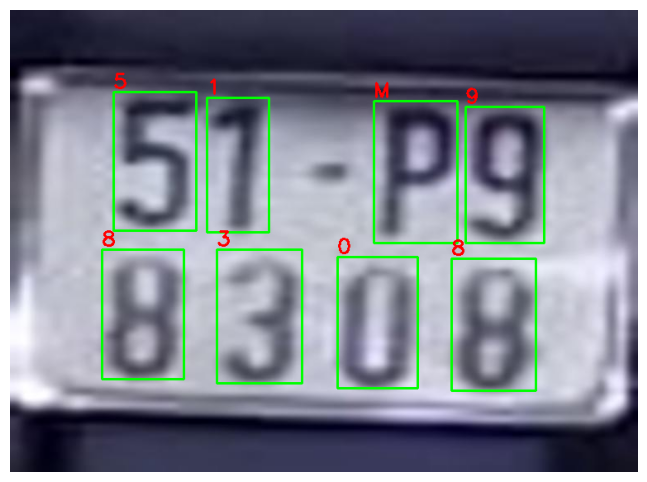

In [ ]:
# ===============================
# Test YOLOv8 OCR Model + Post-processing (Matplotlib)
# ===============================

from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load trained model
model = YOLO("runs/train/Letters_detection/weights/best.pt")

# Mapping class_id → ký tự
names = ['0','1','2','3','4','5','6','7','8','9',
         'A','B','C','D','E','F','G','H','I','J',
         'K','L','M','N','O','P','Q','R','S','T',
         'U','V','W','X','Y','Z']

# Đường dẫn ảnh test
img_path = "data/ocr/images/val/3CarLongPlate739.jpg"

# Inference
results = model.predict(source=img_path, conf=0.25)  # conf threshold

# Lấy prediction bbox và class
pred_boxes = []
for r in results:
    for box in r.boxes:
        x_center, y_center, w, h = box.xywh[0].tolist()
        class_id = int(box.cls[0])
        conf = float(box.conf[0])
        pred_boxes.append({'x_center': x_center, 'y_center': y_center,
                           'w': w, 'h': h, 'class_id': class_id, 'conf': conf})

# Sort bbox theo trục x
pred_boxes_sorted = sorted(pred_boxes, key=lambda b: b['x_center'])

# Ghép class_id → ký tự
pred_text = ''.join([names[b['class_id']] for b in pred_boxes_sorted])
print("Detected text:", pred_text)

# Vẽ bbox + ký tự lên ảnh
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for b in pred_boxes_sorted:
    x, y, w, h = b['x_center'], b['y_center'], b['w'], b['h']
    x1, y1 = int(x - w/2), int(y - h/2)
    x2, y2 = int(x + w/2), int(y + h/2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img, names[b['class_id']], (x1, y1-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

# Hiển thị bằng matplotlib
plt.figure(figsize=(12,6))
plt.imshow(img)
plt.axis('off')
plt.show()


In [13]:
import glob

# Thư mục labels (train hoặc val)
label_folder = "data/ocr/labels/train"  # chỉnh theo folder của bạn
label_files = glob.glob(f"{label_folder}/*.txt")

dataset_min = 100
dataset_max = -1

for f in label_files:
    file_min = 100
    file_max = -1
    with open(f, "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 0:
                continue
            cid = int(parts[0])
            if cid < file_min:
                file_min = cid
            if cid > file_max:
                file_max = cid
            if cid < dataset_min:
                dataset_min = cid
            if cid > dataset_max:
                dataset_max = cid
    print(f"{f}: min_class_id = {file_min}, max_class_id = {file_max}")

print(f"\nDataset overall: min_class_id = {dataset_min}, max_class_id = {dataset_max}")



data/ocr/labels/train\0.txt: min_class_id = 1, max_class_id = 30
data/ocr/labels/train\10PlateBaza299.txt: min_class_id = 4, max_class_id = 29
data/ocr/labels/train\10xemay112.txt: min_class_id = 1, max_class_id = 24
data/ocr/labels/train\10xemay1217.txt: min_class_id = 1, max_class_id = 19
data/ocr/labels/train\10xemay1270.txt: min_class_id = 1, max_class_id = 28
data/ocr/labels/train\10xemay1329.txt: min_class_id = 1, max_class_id = 30
data/ocr/labels/train\10xemay1332.txt: min_class_id = 1, max_class_id = 30
data/ocr/labels/train\10xemay1390.txt: min_class_id = 1, max_class_id = 15
data/ocr/labels/train\10xemay1457.txt: min_class_id = 1, max_class_id = 30
data/ocr/labels/train\10xemay1470.txt: min_class_id = 2, max_class_id = 23
data/ocr/labels/train\10xemay1510.txt: min_class_id = 1, max_class_id = 27
data/ocr/labels/train\10xemay1572.txt: min_class_id = 2, max_class_id = 30
data/ocr/labels/train\10xemay1586.txt: min_class_id = 1, max_class_id = 29
data/ocr/labels/train\10xemay1596

In [14]:
import glob

label_files = glob.glob("data/ocr/labels/**/*.txt", recursive=True)

dataset_min = 100
dataset_max = -1

for f in label_files:
    with open(f, "r") as file:
        for line in file:
            if line.strip() == "":
                continue
            cls = int(line.strip().split()[0])
            dataset_min = min(dataset_min, cls)
            dataset_max = max(dataset_max, cls)

print(f"Dataset class_id range: {dataset_min} → {dataset_max}")


Dataset class_id range: 1 → 30


In [17]:
# ví dụ kiểm tra 1 file
with open("data/ocr/labels/val/8CarLongPlate651.txt") as f:
    for line in f:
        cid = int(line.strip().split()[0])
        print("class_id:", cid, "maps to:", names[cid])


class_id: 30 maps to: U
class_id: 16 maps to: G
class_id: 1 maps to: 1
class_id: 4 maps to: 4
class_id: 5 maps to: 5
class_id: 4 maps to: 4
class_id: 1 maps to: 1
class_id: 30 maps to: U
